In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimi
import sklearn.preprocessing
import sklearn.metrics
import torchvision
from utils.Training_utils import *

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.CustomDataset import CustomDataset
from utils.SimpleDNN import SimpleDNN
from utils.SimpleCNN import SimpleCNN
from SelectNet import *
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




^((?!.*((w_prine)|(w_value)).*).)*$


# Synthesized dataset

(5000, 8) (5000, 1)
0.3208 0.46678406


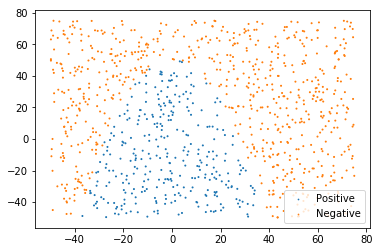

 38%|███▊      | 676817/1800000 [6:49:07<11:23:25, 27.39it/s, acc :      1.000, val_acc :      0.992, loss:      0.003,                              val_loss:     0.0198, w_loss :      0.125, entropy :      2.404,                              regularizer :      0.052                                     -0.5*x2:  0.01,                           x1^2 permutation: 11.48,                              normal random: 85.95,                             x2 permutation: 92.34,                             uniform random:102.14,                            x1 permuatation:124.26,                                         x2:203.84,                                         x1:379.98]

In [ ]:
def F1(x1, x2):
    return 0.02*np.power(x1, 2) + 0.3*x2 - 2.
def F2(x1, x2):
    return -0.5*x2 

N = 5000
low = -50
high = 75
cut = 13
x1 = np.random.uniform(low, high, N)
x2 = np.random.uniform(low, high, N)
x3 = F2(x1, x2)
x4 = np.random.uniform(low, high, N)
x5 = np.random.normal((low+high)/2., 10, N)

x6 = x1[np.random.permutation(N)]
x7 = np.power(x1, 2)[np.random.permutation(N)]
x8 = x2[np.random.permutation(N)]
X = np.swapaxes(np.vstack([x1, x2, x3, x4, x5, x6, x7, x8]), 0, 1)
feature_names = [
            'x1', 'x2', '-0.5*x2', 'uniform random', 'normal random', 
            'x1 permuatation', 'x1^2 permutation', 'x2 permutation',
]

Y = F1(x1, x2).reshape([-1, 1]) < cut
Y = Y.astype(np.float32)
print X.shape, Y.shape
print np.mean(Y), np.std(Y)

# visualization
vis_N = np.random.permutation(N)[:1000]
# pos_mask = (Y < cut)[:vis_N]
# neg_mask = (Y >= cut)[:vis_N]
pos_mask = Y[vis_N] == 1
neg_mask = Y[vis_N] == 0
# print mask
plt.scatter(x1[vis_N], x2[vis_N], marker='o', s=pos_mask, label='Positive')
plt.scatter(x1[vis_N], x2[vis_N], marker='o', s=neg_mask, label='Negative')
plt.legend()
plt.show()
# 
batch_size = 256
N = len(Y)
x_transforms = transforms.Compose([
    transforms.Lambda(lambda x:torch.from_numpy(x)),
    transforms.Lambda(lambda x:x.float()),
    transforms.Lambda(lambda x:x.cuda()),
])
y_transforms = transforms.Compose([
    transforms.Lambda(lambda y:torch.from_numpy(y)),
    transforms.Lambda(lambda y:y.type(torch.float).flatten()),
    transforms.Lambda(lambda y:y.cuda()),
])
# X = sklearn.preprocessing.normalize(X, axis=0)

train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y,
                                                                         x_transforms=x_transforms,
                                                                         y_transforms=y_transforms,
                                                                        ), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)

class Net(nn.Module):
    def __init__(self, in_dim):
        super(Net, self).__init__()
        self.dnn = SimpleDNN(in_dim, 16, 1, 3, F.relu)
        self.kernel_weights = self.dnn.kernel_weights
        
    def forward(self, x):
        x = self.dnn(x)
        return x
def synthesized_noise_fn(x):
    noise_distribution = torch.distributions.Uniform(0.5, 5)
    x[:, 2:] += noise_distribution.sample(x.shape)[:, 2:].cuda()
    return x
ver = 3
p = 1
simple_model = Net(X.shape[-1])
model = SelectNet(X.shape[-1], simple_model, simple_model.kernel_weights, ver, p, use_norm_lay=False).cuda()
opt = torch.optim.Adam(model.parameters())
alpha = 0.1
beta = 100
# beta = 0
gamma = 0
epochs = 100000
iters = 1

src_loss_criterion = nn.BCEWithLogitsLoss()
train(model, opt, src_loss_criterion, train_dataloader, 
      val_dataloader, alpha, beta, gamma, 
      epochs, noise_fn=synthesized_noise_fn, 
      metric_fn=calc_accracy_sigmoid, log_name='Synthesizied', 
      feature_names=feature_names, 
      log_period=10, K=4
     )


In [20]:
X.shape
a = sklearn.preprocessing.normalize(X, axis=0)
print np.mean(a, axis=0)
print np.std(a, axis=0)

[ 0.00462151  0.00472388 -0.00472388  0.00457797  0.01101238  0.00462151
  0.0099789   0.00472388]
[0.01336569 0.01332985 0.01332985 0.01338067 0.00887285 0.01336569
 0.01002106 0.01332985]


In [4]:
pos_mask = Y[vis_N]
neg_mask = Y[vis_N]
# print mask
# plt.scatter(x1[vis_N], x2[vis_N], marker='o', s=pos_mask, label='Positive')
# plt.scatter(x1[vis_N], x2[vis_N], marker='o', s=neg_mask, label='Negative')
# plt.legend()
# plt.show()
# pos_mask
neg_mask

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [4]:
vis_N.shape
Y.shape
Y[vis_N]

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],

In [5]:
l = model.select_lay
l.w.norm(l.p) / 

tensor(79.9920, device='cuda:0', grad_fn=<NormBackward0>)

# Dengue data set

In [ ]:



data = np.load('/home/k123/git/ncku_project/src/medical/data.npz')
iid1 = [0, 1, 9, 10, 11, 24]
iid2 = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 24]
iid3 = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 24, 25, 26, 27, 28, 29, 30, 31]

iid = iid1


X = data['x'][:, iid]
X = data['x']
v_mask = data['missing_mask']
Y = data['y']
X = X[v_mask, :].astype(np.float32)
Y = Y[v_mask, :].astype(np.float32)

print X.shape, Y.shape
print sum(Y)
            

batch_size = 256
N = len(Y)
x_transforms = transforms.Compose([
    transforms.Lambda(lambda x:torch.from_numpy(x)),
    transforms.Lambda(lambda x:x.float()),
    transforms.Lambda(lambda x:x.cuda()),
])
y_transforms = transforms.Compose([
    transforms.Lambda(lambda y:torch.from_numpy(y)),
    transforms.Lambda(lambda y:y.type(torch.float).flatten()),
    transforms.Lambda(lambda y:y.cuda()),
])
            

train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y,
                                                                         x_transforms=x_transforms,
                                                                         y_transforms=y_transforms,
                                                                        ), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)

class Net(nn.Module):
    def __init__(self, in_dim):
        super(Net, self).__init__()
        self.dnn = SimpleDNN(in_dim, 16, 1, 3, F.relu)
        self.kernel_weights = self.dnn.kernel_weights
        
    def forward(self, x):
        x = self.dnn(x)
        return x
def dengue_noise_fn(x):
    noise_distribution = torch.distributions.Uniform(0.5, 1)
    x[:, 0] += noise_distribution.sample(x.shape)[:, 0].cuda()
    return x
simple_model = Net(X.shape[-1])
model = SelectNet(X.shape[-1], simple_model, simple_model.kernel_weights).cuda()
opt = torch.optim.Adam(model.parameters())
alpha = 0.1
beta = 100
# beta = 0
gamma = 0
epochs = 10000
iters = 1
src_loss_criterion = nn.BCEWithLogitsLoss()
feature_names = data['feature_names']
train(model, opt, src_loss_criterion, train_dataloader, 
      val_dataloader, alpha, beta, gamma, 
      epochs, noise_fn=dengue_noise_fn, 
      metric_fn=calc_accracy_sigmoid, log_name='Dengue', 
      feature_names=feature_names, 
      log_period=10, K=4
     )



(4894, 63) (4894, 1)
[2942.]


 24%|██▍       | 43440/180000 [55:10<2:51:29, 13.27it/s, acc :      0.840, val_acc :      0.833, loss:      0.354,                              val_loss:     0.4748, w_loss :      0.001, entropy :      3.697,                              regularizer :      0.054                      Cancer with Metastasis:  0.00,                            Hyperthyroidism:  0.00,                             Mental Illness:  0.00,                            Hyperlipidaemia:  0.00,                                   exam_WBC: 55.44,                              merged_height: 79.23,                                    exam_NA:159.32,                                       Temp:270.19]

In [12]:
w_ratio = model.select_lay.calc_ratio().cpu().detach().numpy().flatten()
sorted_ratio = sorted([(data['feature_names'][i],x) for i,x in enumerate(w_ratio)], key=lambda x:x[1], reverse=True)
for x in sorted_ratio[:22]:
    print x
names = [x[0] for x in sorted_ratio[:22]]
print names
idx =[data['feature_names'].tolist().index(n) for n in names]
print sorted(idx)



(u'Temp', 0.2378159)
(u'exam_NA', 0.09374473)
(u'merged_height', 0.075081654)
(u'exam_WBC', 0.068373166)
(u'exam_Hb', 0.0621576)
(u'exam_CRP', 0.046066813)
(u'SBP', 0.044948414)
(u'sex', 0.039721448)
(u'exam_PT', 0.034997687)
(u'Pulse', 0.033641547)
(u'age', 0.03350617)
(u'exam_APTT', 0.03278675)
(u'merged_weight', 0.02721474)
(u'exam_Plt', 0.025029268)
(u'bmi', 0.024489818)
(u'exam_GLU', 0.023236427)
(u'MAP', 0.021679584)
(u'Breath', 0.021462012)
(u'DBP', 0.020698708)
(u'exam_AST', 0.014917306)
(u'exam_ALT', 0.00986625)
(u'exam_CREA', 0.008563927)
[u'Temp', u'exam_NA', u'merged_height', u'exam_WBC', u'exam_Hb', u'exam_CRP', u'SBP', u'sex', u'exam_PT', u'Pulse', u'age', u'exam_APTT', u'merged_weight', u'exam_Plt', u'bmi', u'exam_GLU', u'MAP', u'Breath', u'DBP', u'exam_AST', u'exam_ALT', u'exam_CREA']
[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24]


# Synthesized XOR data set

(1500, 2)


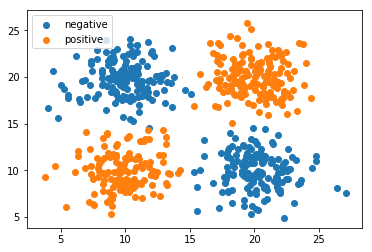

NameError: name 'h' is not defined

In [2]:
def generate_xor(N):
    X = []
    Y = []
    offset = 10
    std = 2
    for i in range(N):
        idx = np.random.randint(0, 4)
        if idx == 0:
            s = np.random.normal([offset, offset], std)
            y = 1
        elif idx == 1:
            s = np.random.normal([2*offset, offset], std)
            y = 0
        elif idx == 2:
            s = np.random.normal([offset, 2*offset], std)
            y = 0
        elif idx == 3:
            s = np.random.normal([2*offset, 2*offset], std)
            y = 1
        X.append(s)
        Y.append(y)
    return np.asarray(X), np.array(Y).reshape([-1, 1])
        

N = 1500
X, Y = generate_xor(N)

print X.shape
display_N = 300
neg_idx, pos_idx = np.where(Y == 0)[0][:display_N], np.where(Y == 1)[0][:display_N]
fig = plt.figure()
# ax = fig.gca(projection='3d')
ax = fig.gca()
ax.scatter(X[neg_idx,0], X[neg_idx, 1], label='negative')
ax.scatter(X[pos_idx,0], X[pos_idx, 1], label='positive')

ax.legend()

plt.show()

X = torch.from_numpy(np.hstack([h, w, iid, iid2]).astype(np.float32))
# X = torch.from_numpy(np.hstack([x1, x2, y1, y2, y3, iid, iid2]).astype(np.float32))
# X = torch.from_numpy(np.hstack([x1, x2, y1, y2, y3, iid, iid2]).astype(np.float32))

# X = torch.from_numpy(x1.astype(np.float32))
# X = torch.from_numpy(np.hstack([x1, iid]).astype(np.float32))
# X, norm = sklearn.preprocessing.normalize(X, axis=0, return_norm=True)
# X = X.astype(np.float32)
# print norm.shape
Y = torch.from_numpy(bmi.astype(np.float32))
# Y = torch.from_numpy(y4.astype(np.float32))
# Y = torch.from_numpy((bmi > 25).astype(np.float32))
print X.shape, Y.shape
batch_size = 128
train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)



DNN_model = SimpleDNN(X.shape[-1], 16, 1, 2, F.relu)
model = SelectNet(X.shape[-1], DNN_model, DNN_model.kernel_weights).cuda()
opt = torch.optim.Adam(model.parameters())
alpha = 0.1
beta = 100
gamma = 0
epochs = 1000
iters = 1
noise_std = 25
noise_col_idx = [2, 3]
writer = SummaryWriter('./AE_logs/XOR-a%f,b%f,g%f' % (alpha, beta, gamma))
with tqdm(total=epochs*len(train_dataloader)) as pbar:
    for epoch in range(epochs):
        for _ in range(len(train_dataloader)):
            x, y = next(train_G)
            noised_x = add_masked_noise(x, noise_std, noise_col_idx)
            x, y = x.cuda(), y.cuda()
            noised_x = noised_x.cuda()
            val_x, val_y = next(val_G)
            val_noised_x = add_masked_noise(val_x, noise_std, noise_col_idx)
            val_x, val_y = val_x.cuda(), val_y.cuda()
            val_noised_x = val_noised_x.cuda()
#             mask
#             x = mask_column(x, mask_idx)
#             val_x = mask_column(val_x, mask_idx)
# 
            model.train()
            out = model(x)
            reg_loss, w_loss, entropy_loss = model.calc_reg_loss(F.mse_loss)
            mse_loss = F.mse_loss(out, y)
            loss = alpha*reg_loss + beta*w_loss + gamma*entropy_loss + mse_loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            with torch.no_grad():
                model.eval()
            
                out = model(val_x)
                val_mse_loss = F.mse_loss(out, val_y)
#                 noised
                noised_mse = F.mse_loss(model(noised_x), y)
                val_noised_mse = F.mse_loss(model(val_noised_x), val_y)
                
            
            pbar.update(1)
            w_arr = model.w.cpu().detach().numpy().flatten()
            w_prine = torch.sigmoid(model.w).cpu().detach().numpy().flatten()
            w_ratio = model.select_lay.calc_ratio().cpu().detach().numpy().flatten()
#             buf = ','.join(['%d:%.2f' % (i+1,x) for i,x in enumerate(buf)])
            buf = ','.join(['%2.3f, ' % (x) for i,x in enumerate(w_ratio)])
            pbar.set_postfix_str('loss: %.3f, val_loss: %.4f, w_loss : %.3f, entropy : %.3f, regularizer : %.3f                     %s' %
                                 (mse_loss.item(), val_mse_loss.item(), 
                                  w_loss.item(), entropy_loss.item(),
                                  reg_loss.item(), buf))
#             if mse_loss.item() < 100:
            if epoch > 0:
                writer.add_scalars('data/loss', {'train': loss.item()},
                                                     iters)
                writer.add_scalars('data/mse_loss', {'train': mse_loss.item(),
                                                     'validation': val_mse_loss.item()},
                                                     iters)
                writer.add_scalars('data/noised_mse_loss', {'train': noised_mse.item(),
                                                     'validation': val_noised_mse.item()},
                                                     iters)
                writer.add_scalars('data/w_loss', {'train': w_loss.item()},
                                                     iters)
                writer.add_scalars('data/entropy', {'train': entropy_loss.item()},
                                                     iters)
                writer.add_scalars('data/reg_loss', {'train': reg_loss.item()},
                                                     iters)
                writer.add_scalars('data/w', {'w%d' % (i+1) : v  for i, v in enumerate(w_arr)},
                                                     iters)
                writer.add_scalars('data/w\'', {'w%d' % (i+1) : v  for i, v in enumerate(w_prine)},
                                                     iters)
                writer.add_scalars('data/w_ratio', {'w%d' % (i+1) : v  for i, v in enumerate(w_ratio)},
                                                     iters)
            
            iters += 1

print 'done 1'

writer.close()

print 'done'



In [17]:
np.where(Y == 0)[0][:200].shape

(200,)

# CIFAR10 DATASET

In [ ]:


batch_size = 128
final_size = 20
final_in_dim = final_size*final_size*3
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = SimpleCNN(3, 16, 3)
        self.kernel_weights = self.cnn.kernel_weights
        self.linear = nn.Linear(4*64, 10)
        
    def forward(self, x):
        batch = x.shape[0]
        x = x.view(batch, 3, final_size, final_size)
        x = self.cnn(x)
        out = self.linear(x.view(batch, -1))
        return out
def cifar_noise_fn(x):
    return x

# Data
print('==> Preparing data..')
x_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([final_size, final_size]),
#     transforms.Grayscale(),
    transforms.RandomCrop(20, padding=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Lambda(lambda x:x.float().flatten()),
    transforms.Lambda(lambda x:x.cuda()),
])
y_transforms = transforms.Compose([
    transforms.Lambda(lambda y:torch.from_numpy(y).type(torch.long).flatten()),
    transforms.Lambda(lambda y:y.cuda()),
])


trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=None)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=None)


train_dataset = CustomDataset(trainset.train_data, np.array(trainset.train_labels).reshape([-1, 1]),
                             x_transforms=x_transforms,
                             y_transforms=y_transforms,
                             )
val_dataset = CustomDataset(testset.test_data, np.array(testset.test_labels).reshape([-1, 1]),
                            x_transforms=x_transforms,
                            y_transforms=y_transforms,
                           )
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



G = generator(train_dataset)
# DNN_model = SimpleDNN(X.shape[-1], 128, 10, 3, F.relu)
# model = SelectNet(X.shape[-1], DNN_model, DNN_model.kernel_weights).cuda()
simple_model = Net()
model = SelectNet(final_in_dim, simple_model, simple_model.kernel_weights).cuda()
opt = torch.optim.Adam(model.parameters())
alpha = 0.1
beta = 100
# beta = 0
gamma = 0
epochs = 10000
iters = 1
src_loss_criterion = nn.CrossEntropyLoss()
feature_names = ['pixel_%d' % (i+1) for i in range(final_in_dim)]
train(model, opt, src_loss_criterion, train_dataloader, 
      val_dataloader, alpha, beta, gamma, 
      epochs, noise_fn=cifar_noise_fn, 
      metric_fn=calc_accracy_softmax, log_name='Cifar-10', 
      feature_names=feature_names,
      log_period=50, K=4
     )


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


  1%|▏         | 55748/3910000 [6:54:21<492:37:00,  2.17it/s, acc :      0.719, val_acc :      0.703, loss:      0.835,                              val_loss:     0.8734, w_loss :      0.002, entropy :     10.192,                              regularizer :      0.053                                  pixel_1181:  0.17,                                    pixel_1:  0.23,                                  pixel_820:  0.26,                                   pixel_20:  0.26,                                  pixel_668:  1.11,                                  pixel_708:  1.12,                                  pixel_710:  1.12,                                  pixel_589:  1.12]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (sec

  3%|▎         | 123814/3910000 [14:41:17<431:44:52,  2.44it/s, acc :      0.805, val_acc :      0.742, loss:      0.561,                              val_loss:     0.7971, w_loss :      0.001, entropy :     10.203,                              regularizer :      0.102                                     pixel_1:  0.26,                                 pixel_1181:  0.28,                                   pixel_20:  0.30,                                  pixel_861:  0.34,                                  pixel_769:  1.09,                                  pixel_631:  1.09,                                  pixel_402:  1.09,                                  pixel_768:  1.11]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (s

In [12]:
np.array(trainset.train_labels).shape

(50000,)

# MNIST DATASET

In [2]:
from torchvision import datasets, transforms
from utils.SimpleCNN import SimpleCNN
import sklearn.metrics
def calc_accracy(y, out):
    label = y.flatten().cpu().detach().numpy().astype(np.int)
    pred = torch.argmax(out, dim=-1).cpu().detach().numpy().astype(np.int)
    return sklearn.metrics.accuracy_score(label, pred)

def add_noise_on_pixel(x, pixel_mask, distribution):
    noise = distribution.sample(x.size())
    batch = x.shape[0]
    ret = x.clone()
    ret += pixel_mask.repeat(batch, 1).type(torch.FloatTensor)*noise
    return ret
            
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn = SimpleCNN(1, 16, 2)
        self.kernel_weights = self.cnn.kernel_weights
        self.linear = nn.Linear(4*32, 10)
        
    def forward(self, x):
        batch = x.shape[0]
        x = x.view(batch, 1, 10, 10)
        x = self.cnn(x)
        out = self.linear(x.view(batch, -1))
        return out

batch_size = 256

train_dataloader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize([10,10]),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(lambda x:x.flatten()),
                       ])),
        batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.Resize([10,10]),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(lambda x:x.flatten()),
                       ])),
        batch_size=batch_size, shuffle=True)


train_G = generator(train_dataloader)
val_G = generator(val_dataloader)

X = np.zeros([50000, 100])

# DNN_model = SimpleDNN(X.shape[-1], 128, 10, 3, F.relu)
# model = SelectNet(X.shape[-1], DNN_model, DNN_model.kernel_weights).cuda()
simple_model = Net()
model = SelectNet(X.shape[-1], simple_model, simple_model.kernel_weights).cuda()
opt = torch.optim.Adam(model.parameters())
alpha = 0.1
beta = 100
# beta = 0
gamma = 0
epochs = 10000
iters = 1
noise_distribution = torch.distributions.Uniform(0.5, 1)
noise_pixel_mask = torch.tensor([[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 1, 1]], dtype=torch.uint8)
writer = SummaryWriter('./logs/noised_cnn_mnist-a%f,b%f,g%f' % (alpha, beta, gamma))
src_loss_criterion = nn.CrossEntropyLoss()
with tqdm(total=epochs*len(train_dataloader)) as pbar:
    for epoch in range(epochs):
#         mask_idx = np.random.randint(0, X.shape[-1])
        for _ in range(len(train_dataloader)):
            x, y = next(train_G)
            noised_x = add_noise_on_pixel(x, noise_pixel_mask, noise_distribution)
            x, y = x.cuda(), y.type(torch.long).flatten().cuda()
            noised_x = noised_x.cuda()
            val_x, val_y = next(val_G)
            val_noised_x = add_noise_on_pixel(val_x, noise_pixel_mask, noise_distribution)
            val_x, val_y = val_x.cuda(), val_y.type(torch.long).flatten().cuda()
            val_noised_x = val_noised_x.cuda()
# 
            model.train()
            train_out = model(x)
            reg_loss, w_loss, entropy_loss = model.calc_reg_loss(F.mse_loss)
            src_loss = src_loss_criterion(train_out, y)
            loss = alpha*reg_loss + beta*w_loss + gamma*entropy_loss + src_loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            
            with torch.no_grad():
                model.eval()
            
#                 val_out = torch.softmax(model(val_x), dim=-1)
                val_out = model(val_x)
                val_src_loss = src_loss_criterion(val_out, val_y)
                
                
#                 noised
                noised_train_out = model(noised_x)
                noised_val_out = model(val_noised_x)
                noised_src = src_loss_criterion(noised_train_out, y)
                val_noised_src = src_loss_criterion(noised_val_out, val_y)
#                 acc
                train_acc = calc_accracy(y, train_out)
                val_acc = calc_accracy(val_y, val_out)
                noised_train_acc = calc_accracy(y, noised_train_out)
                noised_val_acc = calc_accracy(val_y, noised_val_out)
                
            
            
            pbar.update(1)
            w_arr = model.w.cpu().detach().numpy().flatten()
            w_prine = torch.sigmoid(model.w).cpu().detach().numpy().flatten()
            w_ratio = model.select_lay.calc_ratio().cpu().detach().numpy().flatten()
            sorted_ratio = sorted([(i+1,x) for i,x in enumerate(w_ratio)], key=lambda x:x[1])
            buf = sorted_ratio[:5] + sorted_ratio[-5:]
            buf = ','.join(['w%d:%.2f' % (i,x*1000) for i,x in buf])
            pbar.set_postfix_str('acc : %.3f, val_acc : %.3f, loss: %.3f, val_loss: %.4f, w_loss : %.3f, entropy : %.3f, regularizer : %.3f %s' %
                                 (
                                     train_acc.item(), val_acc.item(),
                                     src_loss.item(), val_src_loss.item(), 
                                     w_loss.item(), entropy_loss.item(),
                                     reg_loss.item(), buf))
            if epoch >= 0 and iters % 10 == 0:
                writer.add_scalars('data/loss', {'train': loss.item()},
                                                     iters)
                writer.add_scalars('data/cross-entropy', {'train': src_loss.item(),
                                                     'validation': val_src_loss.item()},
                                                     iters)
                writer.add_scalars('data/noised_loss', {'train': noised_src.item(),
                                                     'validation': val_noised_src.item()},
                                                     iters)
                writer.add_scalars('data/accuracy', {'train': train_acc.item(),
                                                     'validation': val_acc.item(),
                                                     'noised_train': noised_train_acc.item(),
                                                     'noised_validation': noised_val_acc.item(),
                                                    },
                                                     iters)
                writer.add_scalars('data/w_loss', {'train': w_loss.item()},
                                                     iters)
                writer.add_scalars('data/entropy', {'train': entropy_loss.item()},
                                                     iters)
                writer.add_scalars('data/reg_loss', {'train': reg_loss.item()},
                                                     iters)
                writer.add_scalars('data/w', {'w%d' % (i+1) : v  for i, v in enumerate(w_arr)},
                                                     iters)
                writer.add_scalars('data/w_prine', {'w%d' % (i+1) : v  for i, v in enumerate(w_prine)},
                                                     iters)
                writer.add_scalars('data/w_ratio', {'w%d' % (i+1) : v  for i, v in enumerate(w_ratio)},
                                                     iters)
                writer.add_scalars('data/w_z', {'nothing':0 },
                                                     iters)
            
            
            iters += 1

print 'done 1'

writer.close()

print 'done'



  0%|          | 3363/2350000 [04:30<50:26:18, 12.92it/s, acc : 0.996, val_acc : 0.977, loss: 0.017, val_loss: 0.0630, w_loss : 0.982, entropy : 6.644, regularizer : 0.011 w37:10.00,w54:10.00,w26:10.00,w64:10.00,w34:10.00,w57:10.00,w58:10.00,w36:10.00,w75:10.00,w66:10.00]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  9%|▉         | 220736/2350000 [4:54:00<47:09:08, 12.54it/s, acc : 0.996, val_acc : 0.988, loss: 0.046, val_loss: 0.0790, w_loss : 0.000, entropy : 5.803, regularizer : 0.020 w91:0.00,w99:0.00,w10:0.00,w90:0.00,w1:0.00,w54:22.19,w55:22.34,w77:22.56,w38:23.80,w86:24.67] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
T

KeyboardInterrupt: 

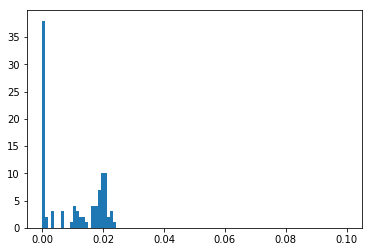

In [28]:
# torch.save(model, './models/mnist_10x10.hdf5')
# print val_x.shape
# print sorted_ratio
# print ['%.5f' % w for w in sorted_ratio]
s = 0
for i, (_, w) in enumerate(reversed(sorted_ratio)):
    s += w
#     print '%3d, %.7f, %.7f' % (i, s, w)
# print ['%d, %.7f' % w[1] for w in sorted_ratio]
# print w_ratio
# plt.plot(np.ones([100,]), w_ratio, 'r.')
ratio = model.select_lay.calc_ratio().cpu().detach().numpy().flatten()
plt.hist(ratio, bins=np.linspace(0, 0.1, 100))
plt.show()

In [135]:
a = torch.tensor([[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 1, 1]], dtype=torch.uint8)
print a

tensor([[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 1, 1]], dtype=torch.uint8)


In [15]:
threshold = 0.001
def get_torch_mask(model, threshold):
    ratio = model.select_lay.calc_ratio()
    pixel_mask =  ratio*model.select_lay.in_dim < threshold
    return pixel_mask.cpu().detach()
    
def add_noise_on_pixel(x, pixel_mask):
    uniform = torch.distributions.Uniform(0.5, 1)
    noise = uniform.sample(x.size())
    batch = x.shape[0]
    ret = x.clone()
    ret += pixel_mask.repeat(batch, 1).type(torch.FloatTensor)*noise
    return ret

def test_accuracy_with_noise(model, val_G, mask, iters=100):
    mean_acc = []
    model.eval()
    with torch.no_grad():
        for it in xrange(iters):
            x, y = next(val_G)
            x, y = x, y.type(torch.long).flatten().cuda()
            x = add_noise_on_pixel(x, pixel_mask).cuda()
            out = model(x)
            acc = calc_accracy(y, out)
            mean_acc.append(acc)
    return np.mean(mean_acc)
            
    
pixel_mask = get_torch_mask(model, threshold)
print pixel_mask
print pixel_mask.shape
pixel_idx = [i for i in range(pixel_mask.shape[-1]) if pixel_mask[0, i] == 1]
# print np.[pixel_idx]
print test_accuracy_with_noise(model, val_G, pixel_mask, 100)


tensor([[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 1, 1, 1]], dtype=torch.uint8)
torch.Size([1, 100])
0.9859765625


torch.Size([256, 100]) torch.Size([256])
(10, 10, 3) 0.0 1.0
tensor(1)


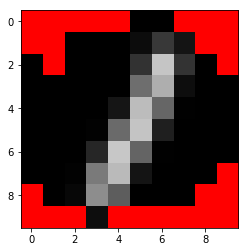

In [17]:
def visualize_noise(img, pixel_mask):
    assert len(img.shape) == 3 and img.shape[-1] == 3
    mask = pixel_mask.reshape(10, 10)
    mask = np.swapaxes(mask, 0, 1)
    
    ret = img.copy()
    np.putmask(ret[:,:,0], mask, 1)
    np.putmask(ret[:,:,1], mask, 0)
    np.putmask(ret[:,:,2], mask, 0)
    return ret

def denormalize(x):
    return x*0.3081 + 0.1307
    
for x, y in val_dataloader:
    print x.shape, y.shape
    break
x = x[0:1,:]
x = denormalize(x)
m = x.numpy()
m = np.repeat(m, 3, axis=0)
# m = add_noise_on_pixel(m, pixel_idx)
m = m.reshape([3, 10, 10])
m = np.swapaxes(m, 0, 2)
m = np.swapaxes(m, 0, 1)
m = visualize_noise(m, pixel_mask)

print m.shape, np.min(m), np.max(m)
print y[0]
plt.imshow(m, cmap=None, vmin=0, vmax=1)

torch.Size([256, 100]) torch.Size([256])
(10, 10, 3) 0.0 1.0
tensor(1)


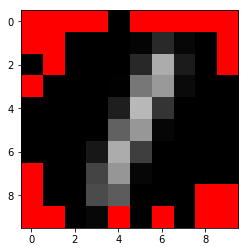

In [108]:
    
def visualize_noise(img, pixel_mask):
    assert len(img.shape) == 3 and img.shape[-1] == 3
    mask = pixel_mask.reshape(10, 10)
    mask = np.swapaxes(mask, 0, 1)
    
    ret = img.copy()
    np.putmask(ret[:,:,0], mask, 1)
    np.putmask(ret[:,:,1], mask, 0)
    np.putmask(ret[:,:,2], mask, 0)
    return ret

def denormalize(x):
    return x*0.3081 + 0.1307
    
for x, y in val_dataloader:
    print x.shape, y.shape
    break
x = x[0:1,:]
x = denormalize(x)
m = x.numpy()
m = np.repeat(m, 3, axis=0)
# m = add_noise_on_pixel(m, pixel_idx)
m = m.reshape([3, 10, 10])
m = np.swapaxes(m, 0, 2)
m = np.swapaxes(m, 0, 1)
m = visualize_noise(m, pixel_mask)

print m.shape, np.min(m), np.max(m)
print y[0]
plt.imshow(m, cmap=None, vmin=0, vmax=1)

In [ ]:
# mnist model visualization

# in Iris dataset

In [ ]:
from sklearn.datasets import load_iris
from sklearn import tree
import sklearn.metrics

def calc_accracy(y, out):
    label = y.flatten().cpu().detach().numpy().astype(np.int)
    pred = torch.argmax(out, dim=-1).cpu().detach().numpy().astype(np.int)
    return sklearn.metrics.accuracy_score(label, pred)
            

iris = load_iris()
X = iris.data.astype(np.float32)
Y = iris.target.reshape([-1, 1]).astype(np.float32)
# print iris.data.shape
N = len(Y)
batch_size = 8
train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)


DNN_model = SimpleDNN(X.shape[-1], 16, 3, 2, F.relu)
model = SelectNet(X.shape[-1], DNN_model, DNN_model.kernel_weights).cuda()
opt = torch.optim.Adam(model.parameters())
alpha = 0.1
beta = 100
gamma = 0
epochs = 10000
iters = 1
noise_std = 25
noise_col_idx = []
writer = SummaryWriter('./AE_logs/Iris-a%f,b%f,g%f' % (alpha, beta, gamma))
src_loss_criterion = nn.CrossEntropyLoss()
with tqdm(total=epochs*len(train_dataloader)) as pbar:
    for epoch in range(epochs):
#         mask_idx = np.random.randint(0, X.shape[-1])
        for _ in range(len(train_dataloader)):
            x, y = next(train_G)
            noised_x = add_masked_noise(x, noise_std, noise_col_idx)
            x, y = x.cuda(), y.type(torch.long).flatten().cuda()
            noised_x = noised_x.cuda()
            val_x, val_y = next(val_G)
            val_noised_x = add_masked_noise(val_x, noise_std, noise_col_idx)
            val_x, val_y = val_x.cuda(), val_y.type(torch.long).flatten().cuda()
            val_noised_x = val_noised_x.cuda()
#             mask
#             x = mask_column(x, mask_idx)
#             val_x = mask_column(val_x, mask_idx)
# 
            model.train()
#             train_out = torch.softmax(model(x), dim=-1)
            train_out = model(x)
            reg_loss, w_loss, entropy_loss = model.calc_reg_loss(F.mse_loss)
            src_loss = src_loss_criterion(train_out, y)
            loss = alpha*reg_loss + beta*w_loss + gamma*entropy_loss + src_loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            
            with torch.no_grad():
                model.eval()
            
#                 val_out = torch.softmax(model(val_x), dim=-1)
                val_out = model(val_x)
                val_src_loss = src_loss_criterion(val_out, val_y)
                
                
#                 noised
                noised_train_out = model(noised_x)
                noised_val_out = model(val_noised_x)
                noised_src = src_loss_criterion(noised_train_out, y)
                val_noised_src = src_loss_criterion(noised_val_out, val_y)
#                 acc
                train_acc = calc_accracy(y, train_out)
                val_acc = calc_accracy(val_y, val_out)
                noised_train_acc = calc_accracy(y, noised_train_out)
                noised_val_acc = calc_accracy(val_y, noised_val_out)
                
            
            
            pbar.update(1)
            w_arr = model.w.cpu().detach().numpy().flatten()
            w_prine = torch.sigmoid(model.w).cpu().detach().numpy().flatten()
            w_ratio = model.select_lay.calc_ratio().cpu().detach().numpy().flatten()
#             buf = ','.join(['%d:%.2f' % (i+1,x) for i,x in enumerate(buf)])
            buf = ','.join(['%2.3f, ' % (x) for i,x in enumerate(w_ratio)])
            pbar.set_postfix_str('acc : %.3f, val_acc : %.3f, loss: %.3f, val_loss: %.4f, w_loss : %.3f, entropy : %.3f, regularizer : %.3f                     %s' %
                                 (
                                     train_acc.item(), val_acc.item(),
                                     src_loss.item(), val_src_loss.item(), 
                                     w_loss.item(), entropy_loss.item(),
                                     reg_loss.item(), buf))
            if epoch > 0:
                writer.add_scalars('data/loss', {'train': loss.item()},
                                                     iters)
                writer.add_scalars('data/cross-entropy', {'train': src_loss.item(),
                                                     'validation': val_src_loss.item()},
                                                     iters)
                writer.add_scalars('data/noised_loss', {'train': noised_src.item(),
                                                     'validation': val_noised_src.item()},
                                                     iters)
                writer.add_scalars('data/accuracy', {'train': train_acc.item(),
                                                     'validation': val_acc.item(),
                                                     'noised_train': noised_train_acc.item(),
                                                     'noised_validation': noised_val_acc.item(),
                                                    },
                                                     iters)
                writer.add_scalars('data/w_loss', {'train': w_loss.item()},
                                                     iters)
                writer.add_scalars('data/entropy', {'train': entropy_loss.item()},
                                                     iters)
                writer.add_scalars('data/reg_loss', {'train': reg_loss.item()},
                                                     iters)
                writer.add_scalars('data/w', {'w%d' % (i+1) : v  for i, v in enumerate(w_arr)},
                                                     iters)
                writer.add_scalars('data/w_prine', {'w%d' % (i+1) : v  for i, v in enumerate(w_prine)},
                                                     iters)
                writer.add_scalars('data/w_ratio', {'w%d' % (i+1) : v  for i, v in enumerate(w_ratio)},
                                                     iters)
            
            iters += 1

print 'done 1'

writer.close()

print 'done'



# Iris keras

In [69]:
import keras
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm
from keras.models import *
from keras.layers import *
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from keras.backend.tensorflow_backend import set_session
from itertools import combinations
from prettytable import PrettyTable

iris = load_iris()
X = iris.data.astype(np.float32)
buf = (X[:,1] * X[:,3]).reshape([-1, 1])
X = np.concatenate([X, buf], axis=1)
Y = iris.target.reshape([-1, 1]).astype(np.float32)
buf = X[:]
def init_sess():
    K.clear_session()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                        # (nothing gets printed in Jupyter, only if you run it standalone)
    sess = tf.Session(config=config)
    set_session(sess)  # set this TensorFlow session as the default session for Keras

def train_model(X, Y, iters, pbar):
    input_dim = X.shape[-1]
    arr = []
    cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        
    for i in range(iters):
        init_sess()
        X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.3)
        model = Sequential()
        model.add(Dense(64,input_shape=(input_dim,), activation='relu'))
#         model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
#         model.add(Dropout(0.2))
        model.add(Dense(3, activation='softmax'))
        model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
        model.fit(X_train,y_train, epochs=500,batch_size=5,
                  verbose=0, validation_data=[X_test, y_test],
                  callbacks=[cb]
                 )
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        arr.append(accuracy)
        pbar.update(1)
    return np.mean(arr)
idx_set = []
feature_names = iris.feature_names + ['sw * pw']
for i in range(len(feature_names)):
    for idxs in combinations(np.arange(len(feature_names)), i+1):
        idx_set.append(list(idxs))
print idx_set
# print X.shape
iters = 30
acc_arr = []
with tqdm(total=len(idx_set)*iters) as pbar:
    for idx in idx_set:
        acc = train_model(X[:, idx], Y, iters, pbar)
        acc_arr.append([idx, acc])
acc_arr = sorted(acc_arr, key=lambda x: x[1], reverse=True)
T = PrettyTable()
T.field_names = ["Rank", "Accuracy over %d " % iters, "using features"]
for i, (idx, acc) in enumerate(acc_arr):
    row = [i+1, acc, idx + [feature_names[x] for x in idx]]
    T.add_row(row)
print T    


  0%|          | 0/930 [00:00<?, ?it/s]

[[0], [1], [2], [3], [4], [0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4], [0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 2, 3], [0, 2, 4], [0, 3, 4], [1, 2, 3], [1, 2, 4], [1, 3, 4], [2, 3, 4], [0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 3, 4], [0, 2, 3, 4], [1, 2, 3, 4], [0, 1, 2, 3, 4]]


100%|██████████| 930/930 [28:41<00:00,  2.21s/it]

+------+---------------------+--------------------------------------------------------------------------------------------------------------+
| Rank |  Accuracy over 30   |                                                using features                                                |
+------+---------------------+--------------------------------------------------------------------------------------------------------------+
|  1   |  0.9603174605066814 |        [0, 1, 2, 3, 'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']        |
|  2   |  0.9561904764743079 |             [1, 2, 3, 4, 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'sw * pw']             |
|  3   |  0.9523809526080176 |                        [1, 2, 4, 'sepal width (cm)', 'petal length (cm)', 'sw * pw']                         |
|  4   |  0.9507936510207161 | [0, 1, 2, 3, 4, 'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'sw * pw'] |
|  5  

In [72]:
T = PrettyTable()
T.field_names = ["Rank", "Accuracy over %d " % iters, "using features"]
for i, (idx, acc) in enumerate(acc_arr):
    acc = '%.3f' % acc
    row = [i+1, acc, idx + [feature_names[x].replace(' (cm)','') for x in idx]]
    T.add_row(row)
print T 

+------+-------------------+------------------------------------------------------------------------------------------+
| Rank | Accuracy over 30  |                                      using features                                      |
+------+-------------------+------------------------------------------------------------------------------------------+
|  1   |       0.960       |        [0, 1, 2, 3, 'sepal length', 'sepal width', 'petal length', 'petal width']        |
|  2   |       0.956       |          [1, 2, 3, 4, 'sepal width', 'petal length', 'petal width', 'sw * pw']           |
|  3   |       0.952       |                   [1, 2, 4, 'sepal width', 'petal length', 'sw * pw']                    |
|  4   |       0.951       | [0, 1, 2, 3, 4, 'sepal length', 'sepal width', 'petal length', 'petal width', 'sw * pw'] |
|  5   |       0.951       |                             [1, 4, 'sepal width', 'sw * pw']                             |
|  6   |       0.946       |            

In [32]:
print '%s' % ([iris.feature_names[x] for x in idxs ])
print idxs

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
(0, 1, 2, 3)


In [ ]:
print x.shape

In [ ]:
cnn = nn.Conv2d(1, 16, 3, padding=1)
print cnn.weight.shape

In [ ]:
def eval_noise(model, val_G, label, iters=100):
    x_ax = np.linspace(1, 30, 100)
    src_arr = []
    noised_arr = []
    for std in x_ax:
        src_mse_loss = 0
        noised_mse_loss = 0
        normal = torch.distributions.Normal(0, std)
        for i in range(iters):
            val_x, val_y = next(val_G)
            val_x, val_y = val_x.cuda(), val_y.cuda()
            N = val_x.shape[0]
            noise = torch.cat([torch.zeros_like(val_x)[:,:-2], normal.sample([N,2]).cuda()], dim=1)
            out1,_ = model(val_x)
            out2,_ = model(val_x + noise)
            src_mse_loss += F.mse_loss(out1, val_y)
            noised_mse_loss += F.mse_loss(out2, val_y)
        src_mse_loss /= iters
        noised_mse_loss /= iters
        src_arr.append(src_mse_loss.item())
        noised_arr.append(noised_mse_loss.item())
    
#     plt.plot(x_ax, src_arr, label=label + ' mse')
    plt.plot(x_ax, noised_arr, label=label + ' mse with noise')
# eval_noise(att_model, val_G, 'selection', 10)
eval_noise(model, val_G, 'src', 10 )
plt.legend()
plt.show()

Iris data set

In [ ]:
print X.shape, Y.shape
print Y

In [ ]:
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
X = iris.data.astype(np.float32)
Y = iris.target.reshape([-1, 1]).astype(np.float32)
# print iris.data.shape
N = len(Y)
batch_size = 32
train_dataset, val_dataset = torch.utils.data.random_split(CustomDataset(X, Y), [N-N//10, N//10])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_G = generator(train_dataloader)
val_G = generator(val_dataloader)

model = Attention_Autoendecoder(X.shape[-1]).cuda()
# opt = optim.Adam(model.parameters(), lr=0.01)
opt = optim.Adam(model.parameters())
alpha = 100
beta = 0
epochs = 1000
iters = 1
noise_std = 5
noise_col_idx = [2, 3]
writer = SummaryWriter('./AE_logs/Iris-a%f,b%f' % (alpha, beta))
reg_l2_coe = 0.1
with tqdm(total=epochs*len(train_dataloader)) as pbar:
    for epoch in range(epochs):
        mask_idx = np.random.randint(0, X.shape[-1])
        for _ in range(len(train_dataloader)):
            x, y = next(train_G)
            noised_x = add_masked_noise(x, noise_std, noise_col_idx)
            x, y = x.cuda(), y.cuda()
            noised_x = noised_x.cuda()
            val_x, val_y = next(val_G)
            val_noised_x = add_masked_noise(val_x, noise_std, noise_col_idx)
            val_x, val_y = val_x.cuda(), val_y.cuda()
            val_noised_x = val_noised_x.cuda()
#             mask
#             x = mask_column(x, mask_idx)
#             val_x = mask_column(val_x, mask_idx)
# 
            model.train()
            out, att_w = model(x)
            w_ = torch.softmax(att_w, dim=-1)
            mse_loss = F.mse_loss(out, y)
            att_loss = alpha*(F.l1_loss(att_w, torch.zeros_like(att_w)) + beta*entropy_loss(w_))
            reg_loss = reg_l2_coe * regularizer(model.kernel_weights, F.mse_loss)
            loss = att_loss + mse_loss + reg_loss
            opt.zero_grad()
            loss.backward()
            opt.step()
            with torch.no_grad():
                model.eval()
                out, _ = model(val_x)
                val_mse_loss = F.mse_loss(out, val_y)
                val_loss = att_loss + val_mse_loss + reg_loss
#                 noised
                noised_mse = F.mse_loss(model(noised_x)[0], y)
                val_noised_mse = F.mse_loss(model(val_noised_x)[0], val_y)
                
            
            pbar.update(1)
            w_arr = model.w.cpu().detach().numpy().flatten()
            att_w_arr = att_w.cpu().detach().numpy().flatten()
            ratio_w = (att_w / torch.sum(att_w)).cpu().detach().numpy().flatten()
#             buf = ','.join(['%d:%.2f' % (i+1,x) for i,x in enumerate(buf)])
            buf = ','.join(['%2.3f, ' % (x) for i,x in enumerate(ratio_w)])
            buf += 'l1 %.3f, entropy %.3f' % (F.l1_loss(att_w, torch.zeros_like(att_w)).item(), entropy_loss(w_).item())
            pbar.set_postfix_str('loss: %.3f, val_loss: %.4f, att_loss : %.3f, regularizer : %.3f                     %s' %
                                 (mse_loss.item(), val_mse_loss.item(), 
                                  att_loss.item(),
                                  reg_loss.item(), buf))
#             if mse_loss.item() < 100:
            if epoch > 0:
                writer.add_scalars('data/loss', {'train': loss.item(),
                                                     'validation': val_loss.item()},
                                                     iters)
                writer.add_scalars('data/mse_loss', {'train': mse_loss.item(),
                                                     'validation': val_mse_loss.item()},
                                                     iters)
                writer.add_scalars('data/noised_mse_loss', {'train': noised_mse.item(),
                                                     'validation': val_noised_mse.item()},
                                                     iters)
                writer.add_scalars('data/att_loss', {'train': att_loss.item()},
                                                     iters)
                writer.add_scalars('data/reg_loss', {'train': reg_loss.item()},
                                                     iters)
                writer.add_scalars('data/w', {'w%d' % (i+1) : v  for i, v in enumerate(w_arr)},
                                                     iters)
                writer.add_scalars('data/att_w', {'w%d' % (i+1) : v  for i, v in enumerate(att_w_arr)},
                                                     iters)
                writer.add_scalars('data/ratio_att_w', {'w%d' % (i+1) : v  for i, v in enumerate(ratio_w)},
                                                     iters)
            
            iters += 1

print 'done 1'

writer.close()

print 'done'

print att_w[0,: ]

In [ ]:
src_mse_loss = 0
noised_mse_loss = 0
normal = torch.distributions.Normal(0, 20)

for i in range(100):
    val_x, val_y = next(val_G)
    val_x, val_y = val_x.cuda(), val_y.cuda()
    N = val_x.shape[0]
    noise = torch.cat([torch.zeros_like(val_x)[:,:-2], normal.sample([N,2]).cuda()], dim=1)
    out1,_ = model(val_x)
    out2,_ = model(val_x + noise)
    src_mse_loss += F.mse_loss(out1, val_y)
    noised_mse_loss += F.mse_loss(out2, val_y)
    
print src_mse_loss
print noised_mse_loss


In [ ]:
torch.softmax(torch.FloatTensor([1,0,0]), dim=0)
              

In [ ]:
import keras
from keras.models import *
from keras.layers import *

input_x = np.hstack([h, w, iid, iid2])
print input_x.shape
m = Sequential()
m.add(Dense(32, activation='selu'))
m.add(Dense(32, activation='selu'))
m.add(Dense(1, activation='linear'))
m.compile(loss='mse', optimizer='adam')
m.fit(input_x, bmi, epochs=100, batch_size=128, validation_split=0.1)
m.summary()

In [ ]:
print x1.shape
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x1.flatten(), y1.flatten(), y2.flatten(), label='curve')
ax.legend()
print X.shape
plt.show()

In [ ]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
ax.plot(x, y, z, label='parametric curve')
ax.legend()

plt.show()